## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 255
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **NEW DATASET LOADER**

In [2]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [3]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [4]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [5]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [6]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [7]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 8
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 512

layers = 12
heads = 16

resnet_features_channels = 64

In [8]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [9]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:11<00:00, 14530763.05it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [11]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch8-512d-16h-12l_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch8-512d-16h-12l_CIFAR100.pt",
)

# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [00:52<00:00, 29.53it/s]


Epoch : 1 - acc: 0.0774 - loss : 4.1068



100%|██████████| 313/313 [00:03<00:00, 83.86it/s]


test acc: 0.1110 - test loss : 3.8607



100%|██████████| 1563/1563 [00:52<00:00, 29.97it/s]


Epoch : 2 - acc: 0.1287 - loss : 3.7313



100%|██████████| 313/313 [00:03<00:00, 85.74it/s]


test acc: 0.1485 - test loss : 3.5900



100%|██████████| 1563/1563 [00:51<00:00, 30.13it/s]


Epoch : 3 - acc: 0.1588 - loss : 3.5517



100%|██████████| 313/313 [00:03<00:00, 89.95it/s] 


test acc: 0.1765 - test loss : 3.4411



100%|██████████| 1563/1563 [00:53<00:00, 29.46it/s]


Epoch : 4 - acc: 0.1818 - loss : 3.4183



100%|██████████| 313/313 [00:03<00:00, 92.57it/s]


test acc: 0.1953 - test loss : 3.3615



100%|██████████| 1563/1563 [00:53<00:00, 29.20it/s]


Epoch : 5 - acc: 0.1943 - loss : 3.3221



100%|██████████| 313/313 [00:03<00:00, 85.75it/s]


test acc: 0.2170 - test loss : 3.2506



100%|██████████| 1563/1563 [00:54<00:00, 28.87it/s]


Epoch : 6 - acc: 0.2097 - loss : 3.2496



100%|██████████| 313/313 [00:03<00:00, 86.05it/s]


test acc: 0.2240 - test loss : 3.2012



100%|██████████| 1563/1563 [00:53<00:00, 29.12it/s]


Epoch : 7 - acc: 0.2201 - loss : 3.1840



100%|██████████| 313/313 [00:03<00:00, 79.26it/s]


test acc: 0.2364 - test loss : 3.1499



100%|██████████| 1563/1563 [00:53<00:00, 29.43it/s]


Epoch : 8 - acc: 0.2326 - loss : 3.1220



100%|██████████| 313/313 [00:03<00:00, 86.66it/s]


test acc: 0.2470 - test loss : 3.0784



100%|██████████| 1563/1563 [00:53<00:00, 29.16it/s]


Epoch : 9 - acc: 0.2427 - loss : 3.0722



100%|██████████| 313/313 [00:03<00:00, 90.29it/s]


test acc: 0.2574 - test loss : 3.0706



100%|██████████| 1563/1563 [00:53<00:00, 29.12it/s]


Epoch : 10 - acc: 0.2493 - loss : 3.0325



100%|██████████| 313/313 [00:03<00:00, 84.48it/s]


test acc: 0.2566 - test loss : 3.0358



100%|██████████| 1563/1563 [00:53<00:00, 29.23it/s]


Epoch : 11 - acc: 0.2566 - loss : 2.9896



100%|██████████| 313/313 [00:03<00:00, 89.08it/s]


test acc: 0.2677 - test loss : 2.9897



100%|██████████| 1563/1563 [00:53<00:00, 29.26it/s]


Epoch : 12 - acc: 0.2657 - loss : 2.9432



100%|██████████| 313/313 [00:03<00:00, 85.73it/s]


test acc: 0.2634 - test loss : 2.9889



100%|██████████| 1563/1563 [00:53<00:00, 28.99it/s]


Epoch : 13 - acc: 0.2709 - loss : 2.9100



100%|██████████| 313/313 [00:03<00:00, 81.40it/s]


test acc: 0.2669 - test loss : 2.9866



100%|██████████| 1563/1563 [00:53<00:00, 29.12it/s]


Epoch : 14 - acc: 0.2778 - loss : 2.8709



100%|██████████| 313/313 [00:03<00:00, 85.31it/s]


test acc: 0.2812 - test loss : 2.9290



100%|██████████| 1563/1563 [00:53<00:00, 29.22it/s]


Epoch : 15 - acc: 0.2850 - loss : 2.8480



100%|██████████| 313/313 [00:03<00:00, 88.99it/s]


test acc: 0.2820 - test loss : 2.9187



100%|██████████| 1563/1563 [00:53<00:00, 29.07it/s]


Epoch : 16 - acc: 0.2892 - loss : 2.8064



100%|██████████| 313/313 [00:03<00:00, 87.42it/s]


test acc: 0.2867 - test loss : 2.8934



100%|██████████| 1563/1563 [00:53<00:00, 29.39it/s]


Epoch : 17 - acc: 0.2985 - loss : 2.7770



100%|██████████| 313/313 [00:03<00:00, 83.25it/s]


test acc: 0.2918 - test loss : 2.8695



100%|██████████| 1563/1563 [00:53<00:00, 29.18it/s]


Epoch : 18 - acc: 0.3036 - loss : 2.7466



100%|██████████| 313/313 [00:03<00:00, 83.73it/s]


test acc: 0.2947 - test loss : 2.8524



100%|██████████| 1563/1563 [00:53<00:00, 29.42it/s]


Epoch : 19 - acc: 0.3115 - loss : 2.7117



100%|██████████| 313/313 [00:03<00:00, 85.72it/s]


test acc: 0.2938 - test loss : 2.8548



100%|██████████| 1563/1563 [00:53<00:00, 29.32it/s]


Epoch : 20 - acc: 0.3155 - loss : 2.6898



100%|██████████| 313/313 [00:03<00:00, 85.86it/s]


test acc: 0.2992 - test loss : 2.8359



100%|██████████| 1563/1563 [00:53<00:00, 29.07it/s]


Epoch : 21 - acc: 0.3204 - loss : 2.6621



100%|██████████| 313/313 [00:03<00:00, 79.22it/s]


test acc: 0.3081 - test loss : 2.7862



100%|██████████| 1563/1563 [00:53<00:00, 29.09it/s]


Epoch : 22 - acc: 0.3235 - loss : 2.6373



100%|██████████| 313/313 [00:03<00:00, 84.00it/s]


test acc: 0.3025 - test loss : 2.7908



100%|██████████| 1563/1563 [00:53<00:00, 29.01it/s]


Epoch : 23 - acc: 0.3305 - loss : 2.6142



100%|██████████| 313/313 [00:03<00:00, 86.00it/s]


test acc: 0.3098 - test loss : 2.7748



100%|██████████| 1563/1563 [00:53<00:00, 29.20it/s]


Epoch : 24 - acc: 0.3358 - loss : 2.5874



100%|██████████| 313/313 [00:03<00:00, 86.89it/s]


test acc: 0.3146 - test loss : 2.7647



100%|██████████| 1563/1563 [00:53<00:00, 29.13it/s]


Epoch : 25 - acc: 0.3402 - loss : 2.5631



100%|██████████| 313/313 [00:03<00:00, 83.65it/s]


test acc: 0.3179 - test loss : 2.7610



100%|██████████| 1563/1563 [00:53<00:00, 29.23it/s]


Epoch : 26 - acc: 0.3460 - loss : 2.5384



100%|██████████| 313/313 [00:03<00:00, 87.67it/s] 


test acc: 0.3200 - test loss : 2.7289



100%|██████████| 1563/1563 [00:53<00:00, 29.39it/s]


Epoch : 27 - acc: 0.3518 - loss : 2.5151



100%|██████████| 313/313 [00:03<00:00, 83.37it/s]


test acc: 0.3232 - test loss : 2.7193



100%|██████████| 1563/1563 [00:53<00:00, 29.06it/s]


Epoch : 28 - acc: 0.3556 - loss : 2.4867



100%|██████████| 313/313 [00:03<00:00, 88.73it/s]


test acc: 0.3325 - test loss : 2.7071



100%|██████████| 1563/1563 [00:53<00:00, 29.09it/s]


Epoch : 29 - acc: 0.3573 - loss : 2.4727



100%|██████████| 313/313 [00:03<00:00, 82.62it/s]


test acc: 0.3291 - test loss : 2.7103



100%|██████████| 1563/1563 [00:54<00:00, 28.93it/s]


Epoch : 30 - acc: 0.3660 - loss : 2.4424



100%|██████████| 313/313 [00:03<00:00, 91.36it/s]


test acc: 0.3313 - test loss : 2.7056



100%|██████████| 1563/1563 [00:54<00:00, 28.89it/s]


Epoch : 31 - acc: 0.3691 - loss : 2.4245



100%|██████████| 313/313 [00:04<00:00, 78.10it/s]


test acc: 0.3346 - test loss : 2.6995



100%|██████████| 1563/1563 [00:53<00:00, 29.06it/s]


Epoch : 32 - acc: 0.3750 - loss : 2.3987



100%|██████████| 313/313 [00:03<00:00, 84.00it/s]


test acc: 0.3420 - test loss : 2.6755



100%|██████████| 1563/1563 [00:53<00:00, 29.08it/s]


Epoch : 33 - acc: 0.3803 - loss : 2.3714



100%|██████████| 313/313 [00:03<00:00, 87.64it/s]


test acc: 0.3374 - test loss : 2.6742



100%|██████████| 1563/1563 [00:53<00:00, 29.06it/s]


Epoch : 34 - acc: 0.3835 - loss : 2.3548



100%|██████████| 313/313 [00:03<00:00, 78.56it/s]


test acc: 0.3439 - test loss : 2.6489



100%|██████████| 1563/1563 [00:53<00:00, 29.31it/s]


Epoch : 35 - acc: 0.3885 - loss : 2.3292



100%|██████████| 313/313 [00:03<00:00, 85.80it/s]


test acc: 0.3375 - test loss : 2.6661



100%|██████████| 1563/1563 [00:53<00:00, 29.03it/s]


Epoch : 36 - acc: 0.3917 - loss : 2.3124



100%|██████████| 313/313 [00:03<00:00, 84.15it/s]


test acc: 0.3462 - test loss : 2.6383



100%|██████████| 1563/1563 [00:54<00:00, 28.91it/s]


Epoch : 37 - acc: 0.3945 - loss : 2.2937



100%|██████████| 313/313 [00:03<00:00, 88.41it/s]


test acc: 0.3420 - test loss : 2.6538



100%|██████████| 1563/1563 [00:53<00:00, 29.45it/s]


Epoch : 38 - acc: 0.4045 - loss : 2.2617



100%|██████████| 313/313 [00:03<00:00, 85.33it/s]


test acc: 0.3505 - test loss : 2.6458



100%|██████████| 1563/1563 [00:53<00:00, 28.98it/s]


Epoch : 39 - acc: 0.4051 - loss : 2.2482



100%|██████████| 313/313 [00:03<00:00, 93.08it/s] 


test acc: 0.3527 - test loss : 2.6314



100%|██████████| 1563/1563 [00:53<00:00, 29.18it/s]


Epoch : 40 - acc: 0.4083 - loss : 2.2294



100%|██████████| 313/313 [00:03<00:00, 88.40it/s]


test acc: 0.3464 - test loss : 2.6401



100%|██████████| 1563/1563 [00:52<00:00, 29.52it/s]


Epoch : 41 - acc: 0.4154 - loss : 2.2124



100%|██████████| 313/313 [00:03<00:00, 80.03it/s]


test acc: 0.3511 - test loss : 2.6216



100%|██████████| 1563/1563 [00:53<00:00, 29.35it/s]


Epoch : 42 - acc: 0.4225 - loss : 2.1786



100%|██████████| 313/313 [00:03<00:00, 87.52it/s]


test acc: 0.3568 - test loss : 2.6309



100%|██████████| 1563/1563 [00:53<00:00, 29.42it/s]


Epoch : 43 - acc: 0.4241 - loss : 2.1549



100%|██████████| 313/313 [00:03<00:00, 79.34it/s]


test acc: 0.3544 - test loss : 2.6080



100%|██████████| 1563/1563 [00:53<00:00, 29.25it/s]


Epoch : 44 - acc: 0.4301 - loss : 2.1401



100%|██████████| 313/313 [00:03<00:00, 87.55it/s]


test acc: 0.3565 - test loss : 2.5986



100%|██████████| 1563/1563 [00:53<00:00, 29.08it/s]


Epoch : 45 - acc: 0.4355 - loss : 2.1168



100%|██████████| 313/313 [00:03<00:00, 93.73it/s] 


test acc: 0.3595 - test loss : 2.6238



100%|██████████| 1563/1563 [00:53<00:00, 29.44it/s]


Epoch : 46 - acc: 0.4407 - loss : 2.0984



100%|██████████| 313/313 [00:03<00:00, 83.30it/s]


test acc: 0.3591 - test loss : 2.6047



100%|██████████| 1563/1563 [00:53<00:00, 29.15it/s]


Epoch : 47 - acc: 0.4404 - loss : 2.0787



100%|██████████| 313/313 [00:03<00:00, 83.89it/s]


test acc: 0.3645 - test loss : 2.5944



100%|██████████| 1563/1563 [00:53<00:00, 29.39it/s]


Epoch : 48 - acc: 0.4472 - loss : 2.0577



100%|██████████| 313/313 [00:03<00:00, 92.60it/s]


test acc: 0.3655 - test loss : 2.6064



100%|██████████| 1563/1563 [00:53<00:00, 29.32it/s]


Epoch : 49 - acc: 0.4500 - loss : 2.0458



100%|██████████| 313/313 [00:03<00:00, 89.17it/s]


test acc: 0.3678 - test loss : 2.5751



100%|██████████| 1563/1563 [00:53<00:00, 28.99it/s]


Epoch : 50 - acc: 0.4557 - loss : 2.0250



100%|██████████| 313/313 [00:03<00:00, 86.48it/s]


test acc: 0.3712 - test loss : 2.5788



100%|██████████| 1563/1563 [00:53<00:00, 29.39it/s]


Epoch : 51 - acc: 0.4580 - loss : 2.0046



100%|██████████| 313/313 [00:03<00:00, 84.18it/s]


test acc: 0.3677 - test loss : 2.5951



100%|██████████| 1563/1563 [00:53<00:00, 29.13it/s]


Epoch : 52 - acc: 0.4650 - loss : 1.9836



100%|██████████| 313/313 [00:03<00:00, 86.75it/s]


test acc: 0.3640 - test loss : 2.6111



100%|██████████| 1563/1563 [00:53<00:00, 29.10it/s]


Epoch : 53 - acc: 0.4686 - loss : 1.9559



100%|██████████| 313/313 [00:03<00:00, 87.61it/s]


test acc: 0.3710 - test loss : 2.6123



100%|██████████| 1563/1563 [00:53<00:00, 29.22it/s]


Epoch : 54 - acc: 0.4752 - loss : 1.9323



100%|██████████| 313/313 [00:03<00:00, 84.51it/s]


test acc: 0.3692 - test loss : 2.5902



100%|██████████| 1563/1563 [00:53<00:00, 29.06it/s]


Epoch : 55 - acc: 0.4767 - loss : 1.9160



100%|██████████| 313/313 [00:03<00:00, 81.06it/s]


test acc: 0.3760 - test loss : 2.5828



100%|██████████| 1563/1563 [00:53<00:00, 29.27it/s]


Epoch : 56 - acc: 0.4813 - loss : 1.9005



100%|██████████| 313/313 [00:03<00:00, 92.96it/s]


test acc: 0.3707 - test loss : 2.6166



100%|██████████| 1563/1563 [00:53<00:00, 29.25it/s]


Epoch : 57 - acc: 0.4861 - loss : 1.8729



100%|██████████| 313/313 [00:03<00:00, 85.57it/s]


test acc: 0.3746 - test loss : 2.5860



100%|██████████| 1563/1563 [00:53<00:00, 29.31it/s]


Epoch : 58 - acc: 0.4894 - loss : 1.8590



100%|██████████| 313/313 [00:03<00:00, 83.26it/s]


test acc: 0.3712 - test loss : 2.6197



100%|██████████| 1563/1563 [00:53<00:00, 29.14it/s]


Epoch : 59 - acc: 0.4944 - loss : 1.8342



100%|██████████| 313/313 [00:03<00:00, 91.45it/s]


test acc: 0.3686 - test loss : 2.6130



100%|██████████| 1563/1563 [00:53<00:00, 29.37it/s]


Epoch : 60 - acc: 0.5008 - loss : 1.8157



100%|██████████| 313/313 [00:03<00:00, 81.85it/s]


test acc: 0.3831 - test loss : 2.5956



100%|██████████| 1563/1563 [00:53<00:00, 29.27it/s]


Epoch : 61 - acc: 0.5045 - loss : 1.7951



100%|██████████| 313/313 [00:03<00:00, 82.88it/s]


test acc: 0.3801 - test loss : 2.5821



100%|██████████| 1563/1563 [00:53<00:00, 29.36it/s]


Epoch : 62 - acc: 0.5095 - loss : 1.7717



100%|██████████| 313/313 [00:03<00:00, 81.83it/s]


test acc: 0.3815 - test loss : 2.5877



100%|██████████| 1563/1563 [00:53<00:00, 29.22it/s]


Epoch : 63 - acc: 0.5156 - loss : 1.7454



100%|██████████| 313/313 [00:03<00:00, 86.30it/s]


test acc: 0.3713 - test loss : 2.6286



100%|██████████| 1563/1563 [00:53<00:00, 29.22it/s]


Epoch : 64 - acc: 0.5185 - loss : 1.7353



100%|██████████| 313/313 [00:03<00:00, 90.96it/s]


test acc: 0.3842 - test loss : 2.5944



100%|██████████| 1563/1563 [00:52<00:00, 29.58it/s]


Epoch : 65 - acc: 0.5230 - loss : 1.7165



100%|██████████| 313/313 [00:03<00:00, 87.92it/s]


test acc: 0.3807 - test loss : 2.5962



100%|██████████| 1563/1563 [00:53<00:00, 29.12it/s]


Epoch : 66 - acc: 0.5282 - loss : 1.6957



100%|██████████| 313/313 [00:03<00:00, 86.75it/s]


test acc: 0.3824 - test loss : 2.6253



100%|██████████| 1563/1563 [00:53<00:00, 29.11it/s]


Epoch : 67 - acc: 0.5336 - loss : 1.6765



100%|██████████| 313/313 [00:03<00:00, 88.40it/s]


test acc: 0.3838 - test loss : 2.6184



100%|██████████| 1563/1563 [00:53<00:00, 29.15it/s]


Epoch : 68 - acc: 0.5397 - loss : 1.6550



100%|██████████| 313/313 [00:03<00:00, 82.70it/s]


test acc: 0.3789 - test loss : 2.6600



100%|██████████| 1563/1563 [00:53<00:00, 29.29it/s]


Epoch : 69 - acc: 0.5400 - loss : 1.6280



100%|██████████| 313/313 [00:03<00:00, 86.74it/s]


test acc: 0.3893 - test loss : 2.6504



100%|██████████| 1563/1563 [00:53<00:00, 29.07it/s]


Epoch : 70 - acc: 0.5480 - loss : 1.6099



100%|██████████| 313/313 [00:03<00:00, 88.69it/s]


test acc: 0.3851 - test loss : 2.6290



100%|██████████| 1563/1563 [00:53<00:00, 29.24it/s]


Epoch : 71 - acc: 0.5480 - loss : 1.5941



100%|██████████| 313/313 [00:03<00:00, 86.57it/s]


test acc: 0.3840 - test loss : 2.6387



100%|██████████| 1563/1563 [00:53<00:00, 29.27it/s]


Epoch : 72 - acc: 0.5540 - loss : 1.5827



100%|██████████| 313/313 [00:04<00:00, 74.45it/s]


test acc: 0.3822 - test loss : 2.6656



100%|██████████| 1563/1563 [00:53<00:00, 29.41it/s]


Epoch : 73 - acc: 0.5589 - loss : 1.5551



100%|██████████| 313/313 [00:03<00:00, 84.78it/s]


test acc: 0.3848 - test loss : 2.6474



100%|██████████| 1563/1563 [00:53<00:00, 29.07it/s]


Epoch : 74 - acc: 0.5642 - loss : 1.5323



100%|██████████| 313/313 [00:03<00:00, 81.61it/s]


test acc: 0.3823 - test loss : 2.6682



100%|██████████| 1563/1563 [00:53<00:00, 28.95it/s]


Epoch : 75 - acc: 0.5706 - loss : 1.5203



100%|██████████| 313/313 [00:03<00:00, 86.65it/s]


test acc: 0.3848 - test loss : 2.6567



100%|██████████| 1563/1563 [00:53<00:00, 28.99it/s]


Epoch : 76 - acc: 0.5740 - loss : 1.4964



100%|██████████| 313/313 [00:03<00:00, 79.75it/s]


test acc: 0.3860 - test loss : 2.6570



100%|██████████| 1563/1563 [00:53<00:00, 29.33it/s]


Epoch : 77 - acc: 0.5772 - loss : 1.4775



100%|██████████| 313/313 [00:03<00:00, 84.52it/s]


test acc: 0.3874 - test loss : 2.6695



100%|██████████| 1563/1563 [00:53<00:00, 29.03it/s]


Epoch : 78 - acc: 0.5816 - loss : 1.4559



100%|██████████| 313/313 [00:03<00:00, 88.28it/s]


test acc: 0.3932 - test loss : 2.6957



100%|██████████| 1563/1563 [00:53<00:00, 29.47it/s]


Epoch : 79 - acc: 0.5887 - loss : 1.4326



100%|██████████| 313/313 [00:03<00:00, 79.62it/s]


test acc: 0.3852 - test loss : 2.7238



100%|██████████| 1563/1563 [00:54<00:00, 28.93it/s]


Epoch : 80 - acc: 0.5896 - loss : 1.4220



100%|██████████| 313/313 [00:03<00:00, 89.18it/s]


test acc: 0.3884 - test loss : 2.7151



100%|██████████| 1563/1563 [00:53<00:00, 29.10it/s]


Epoch : 81 - acc: 0.5990 - loss : 1.3915



100%|██████████| 313/313 [00:03<00:00, 86.83it/s]


test acc: 0.3882 - test loss : 2.7089



100%|██████████| 1563/1563 [00:53<00:00, 29.06it/s]


Epoch : 82 - acc: 0.6023 - loss : 1.3787



100%|██████████| 313/313 [00:03<00:00, 87.00it/s]


test acc: 0.3828 - test loss : 2.7349



100%|██████████| 1563/1563 [00:53<00:00, 29.16it/s]


Epoch : 83 - acc: 0.6041 - loss : 1.3654



100%|██████████| 313/313 [00:03<00:00, 87.38it/s]


test acc: 0.3889 - test loss : 2.7375



100%|██████████| 1563/1563 [00:53<00:00, 29.18it/s]


Epoch : 84 - acc: 0.6103 - loss : 1.3426



100%|██████████| 313/313 [00:03<00:00, 82.16it/s]


test acc: 0.3808 - test loss : 2.7498



100%|██████████| 1563/1563 [00:53<00:00, 29.16it/s]


Epoch : 85 - acc: 0.6165 - loss : 1.3277



100%|██████████| 313/313 [00:03<00:00, 82.27it/s]


test acc: 0.3895 - test loss : 2.7613



100%|██████████| 1563/1563 [00:53<00:00, 29.32it/s]


Epoch : 86 - acc: 0.6209 - loss : 1.3015



100%|██████████| 313/313 [00:03<00:00, 85.30it/s]


test acc: 0.3883 - test loss : 2.7631



100%|██████████| 1563/1563 [00:53<00:00, 29.34it/s]


Epoch : 87 - acc: 0.6221 - loss : 1.2905



100%|██████████| 313/313 [00:03<00:00, 89.46it/s]


test acc: 0.3861 - test loss : 2.7874



100%|██████████| 1563/1563 [00:54<00:00, 28.83it/s]


Epoch : 88 - acc: 0.6294 - loss : 1.2629



100%|██████████| 313/313 [00:03<00:00, 84.28it/s]


test acc: 0.3918 - test loss : 2.7868



100%|██████████| 1563/1563 [00:52<00:00, 29.50it/s]


Epoch : 89 - acc: 0.6336 - loss : 1.2522



100%|██████████| 313/313 [00:03<00:00, 85.13it/s]


test acc: 0.3896 - test loss : 2.7900



100%|██████████| 1563/1563 [00:53<00:00, 29.10it/s]


Epoch : 90 - acc: 0.6416 - loss : 1.2169



100%|██████████| 313/313 [00:03<00:00, 86.09it/s]


test acc: 0.3861 - test loss : 2.8406



100%|██████████| 1563/1563 [00:53<00:00, 29.04it/s]


Epoch : 91 - acc: 0.6470 - loss : 1.2007



100%|██████████| 313/313 [00:03<00:00, 90.39it/s]


test acc: 0.3850 - test loss : 2.8330



100%|██████████| 1563/1563 [00:53<00:00, 29.06it/s]


Epoch : 92 - acc: 0.6477 - loss : 1.1885



100%|██████████| 313/313 [00:03<00:00, 80.84it/s]


test acc: 0.3888 - test loss : 2.8719



100%|██████████| 1563/1563 [00:53<00:00, 29.04it/s]


Epoch : 93 - acc: 0.6538 - loss : 1.1626



100%|██████████| 313/313 [00:03<00:00, 82.29it/s]


test acc: 0.3833 - test loss : 2.8756



100%|██████████| 1563/1563 [00:53<00:00, 29.15it/s]


Epoch : 94 - acc: 0.6591 - loss : 1.1455



100%|██████████| 313/313 [00:04<00:00, 76.07it/s]


test acc: 0.3888 - test loss : 2.8935



100%|██████████| 1563/1563 [00:53<00:00, 28.96it/s]


Epoch : 95 - acc: 0.6650 - loss : 1.1302



100%|██████████| 313/313 [00:03<00:00, 91.99it/s]


test acc: 0.3857 - test loss : 2.8903



100%|██████████| 1563/1563 [00:54<00:00, 28.94it/s]


Epoch : 96 - acc: 0.6707 - loss : 1.1063



100%|██████████| 313/313 [00:03<00:00, 84.05it/s]


test acc: 0.3860 - test loss : 2.9380



100%|██████████| 1563/1563 [00:53<00:00, 29.13it/s]


Epoch : 97 - acc: 0.6734 - loss : 1.0915



100%|██████████| 313/313 [00:03<00:00, 84.58it/s]


test acc: 0.3863 - test loss : 2.9386



100%|██████████| 1563/1563 [00:54<00:00, 28.67it/s]


Epoch : 98 - acc: 0.6803 - loss : 1.0755



100%|██████████| 313/313 [00:03<00:00, 82.22it/s]


test acc: 0.3866 - test loss : 2.9338



100%|██████████| 1563/1563 [00:54<00:00, 28.73it/s]


Epoch : 99 - acc: 0.6830 - loss : 1.0607



100%|██████████| 313/313 [00:03<00:00, 79.90it/s]


test acc: 0.3904 - test loss : 2.9275



100%|██████████| 1563/1563 [00:54<00:00, 28.88it/s]


Epoch : 100 - acc: 0.6872 - loss : 1.0404



100%|██████████| 313/313 [00:03<00:00, 79.00it/s]


test acc: 0.3896 - test loss : 2.9535

Start Time: 1733068962.3088148
End Time: 1733074692.5474832
Time Taken: 5730.2386684417725 seconds


In [12]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

/tmp/ipykernel_35/3010096064.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


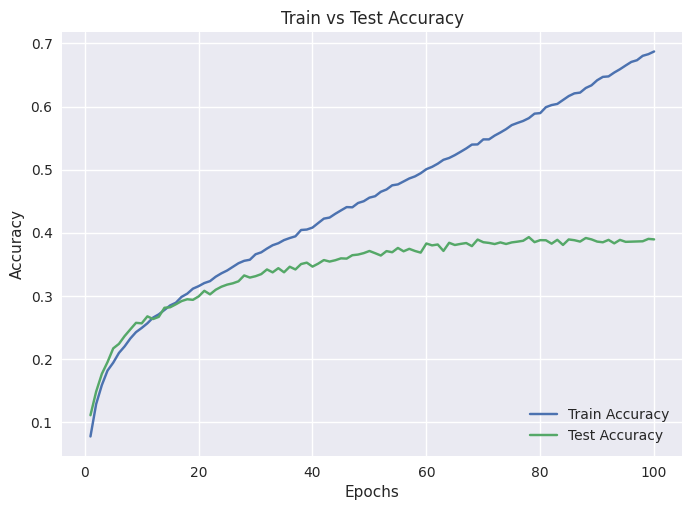

In [13]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [14]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:03<00:00, 96.21it/s] 


####  Superclass confusion matrix

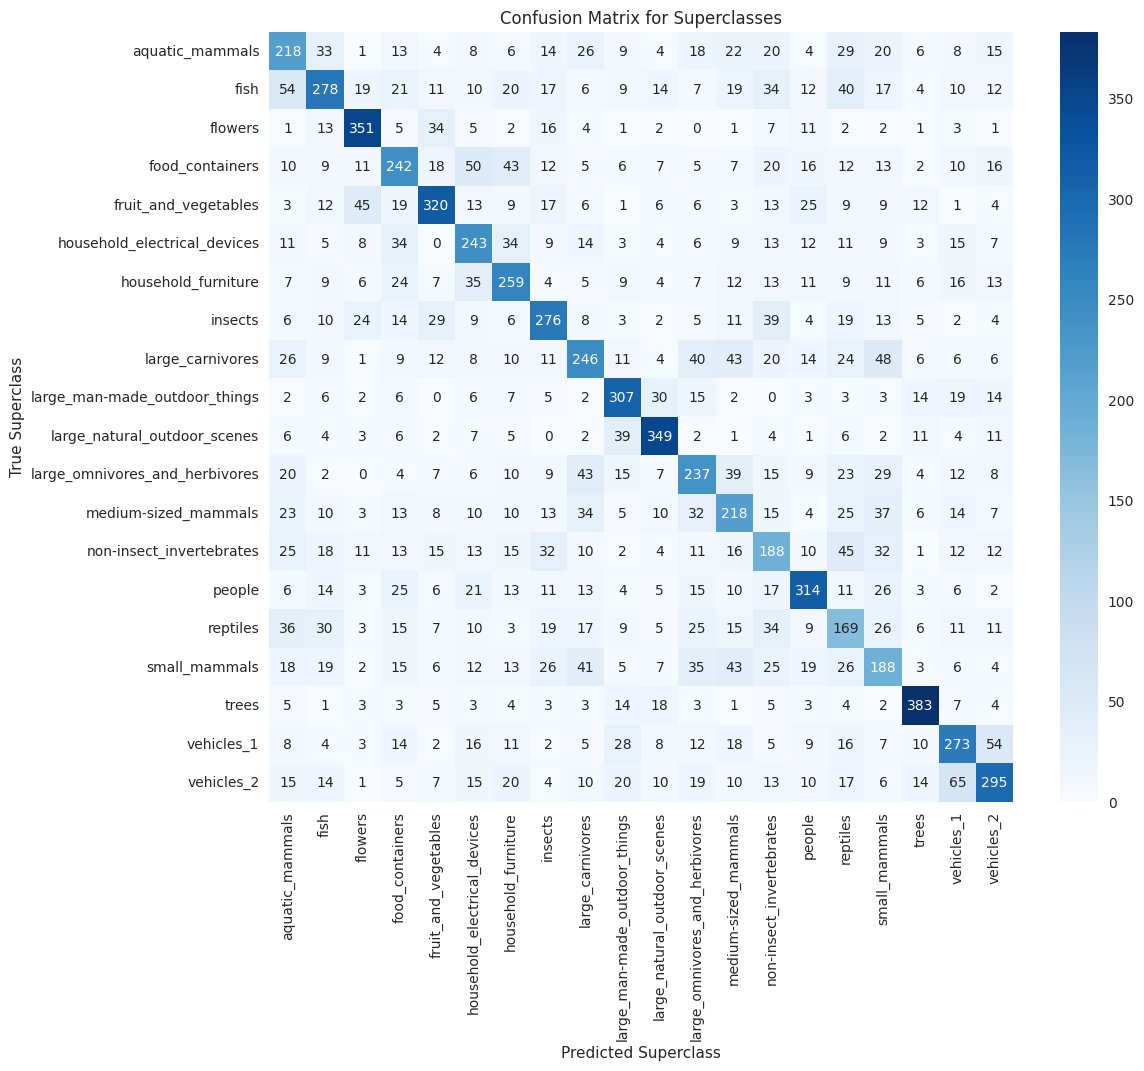

In [15]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

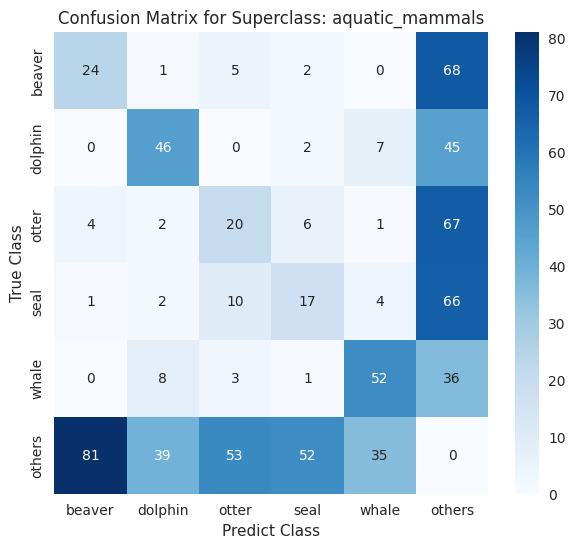

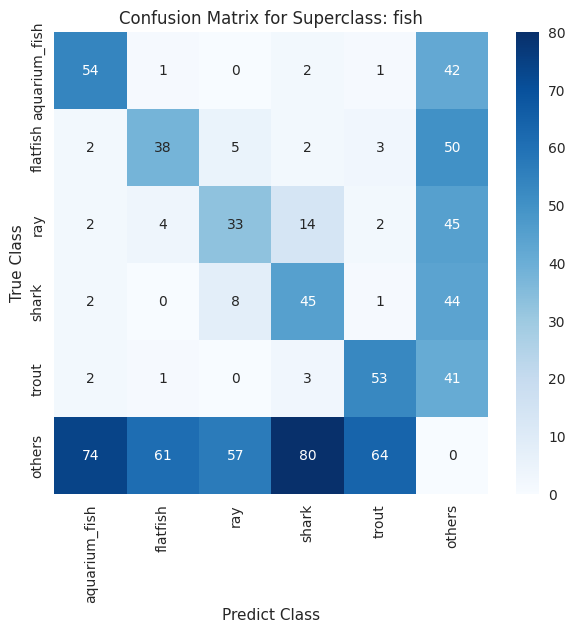

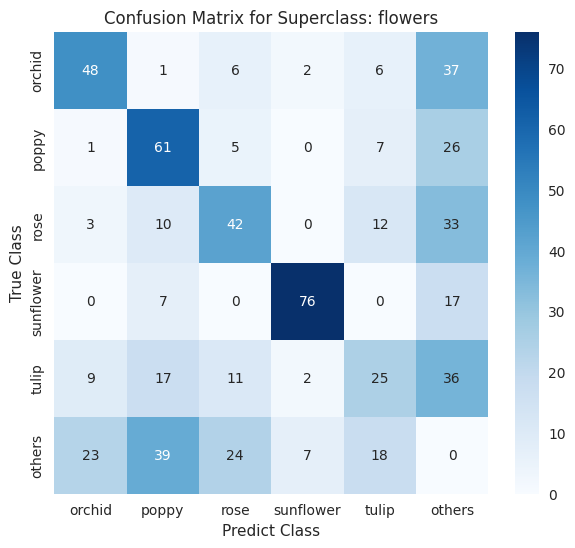

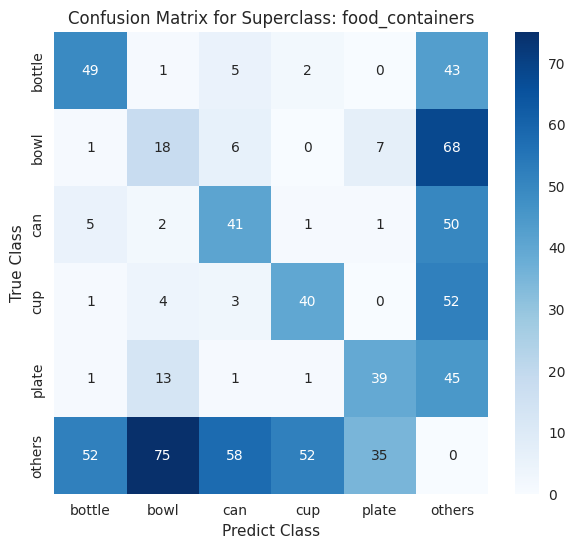

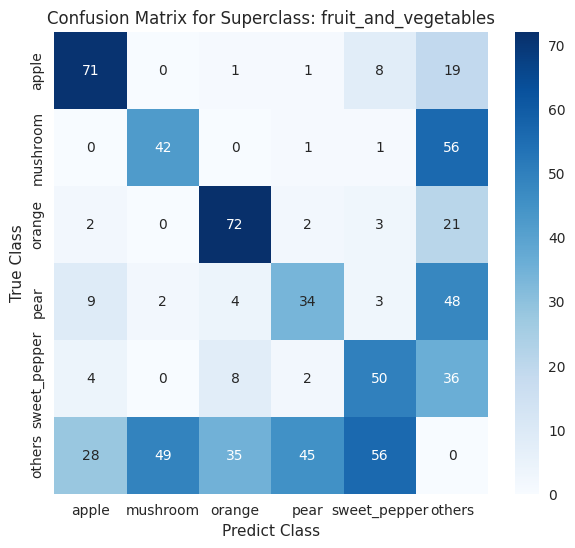

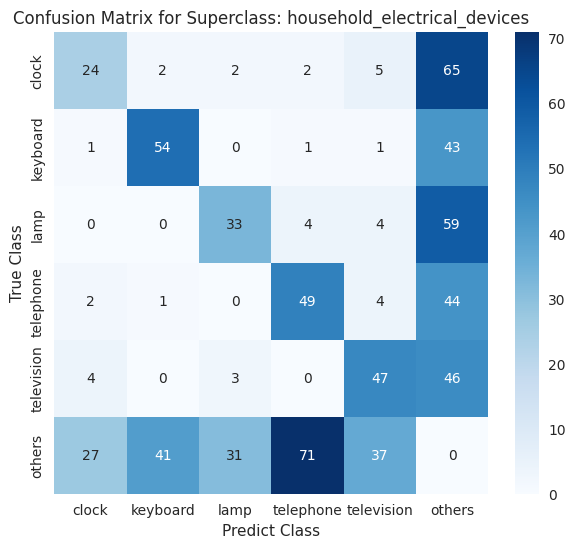

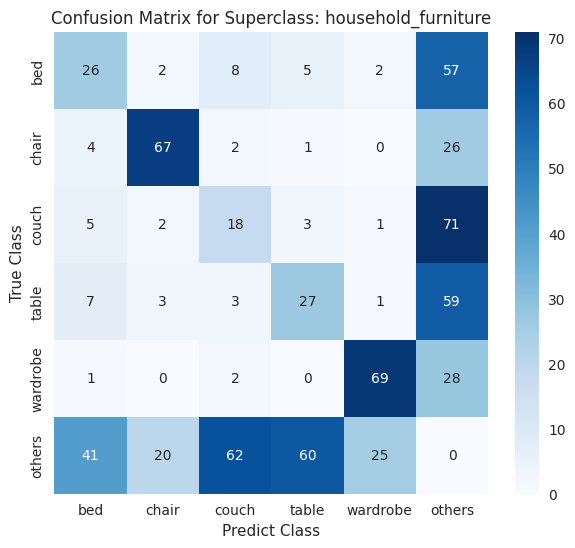

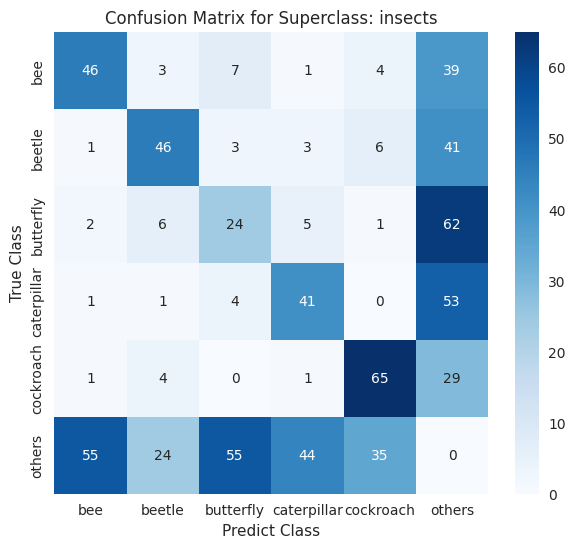

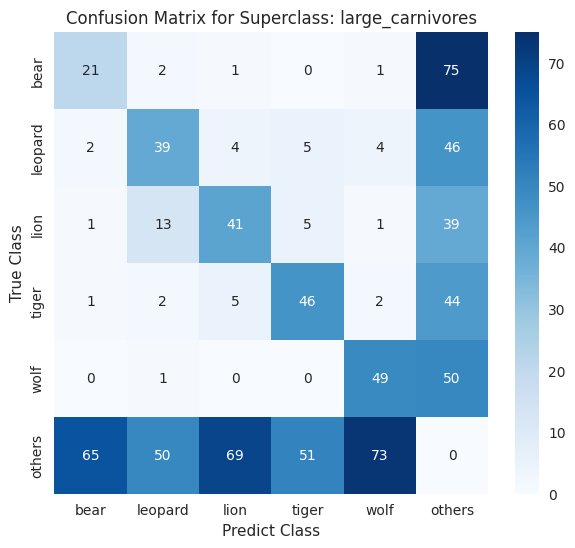

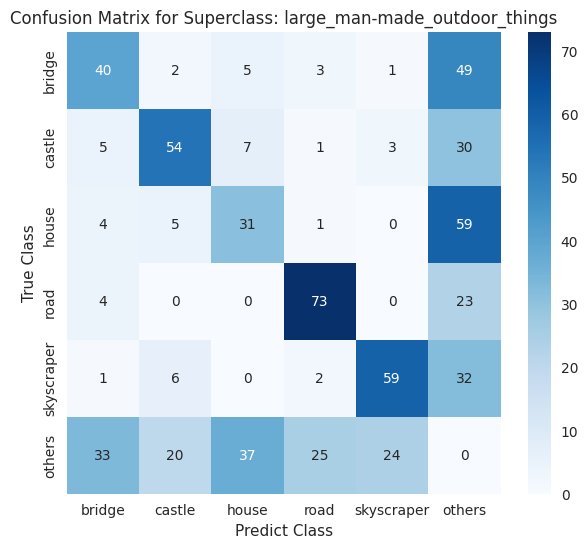

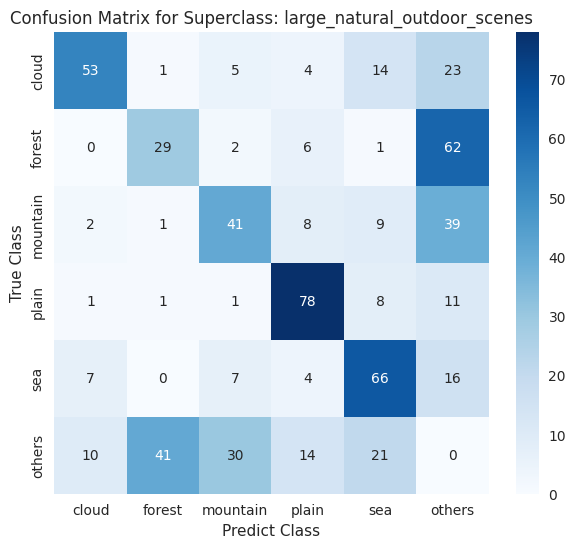

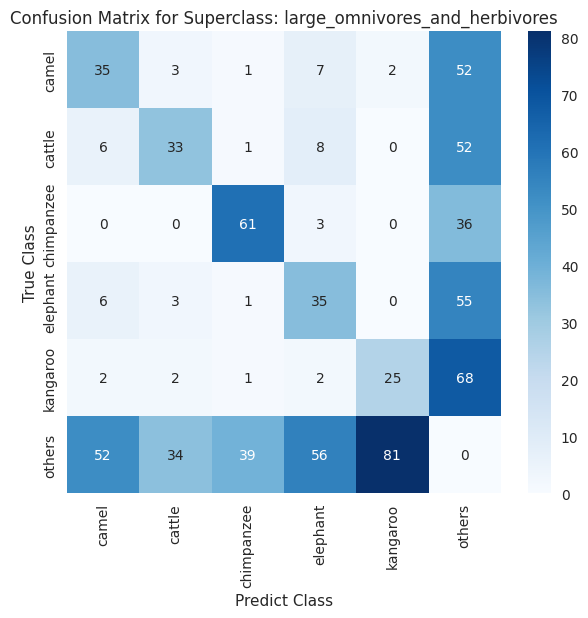

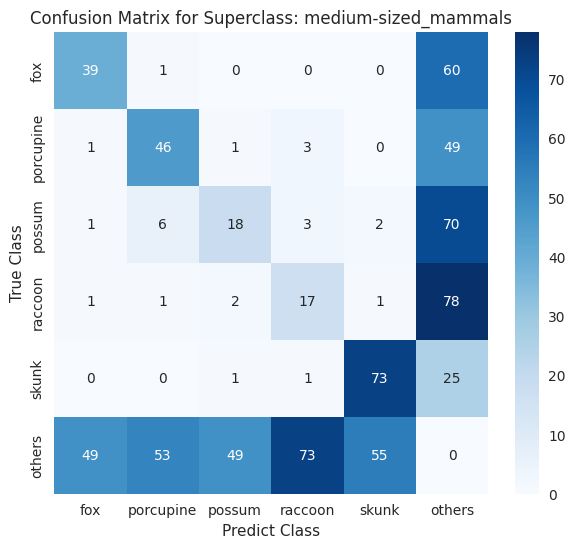

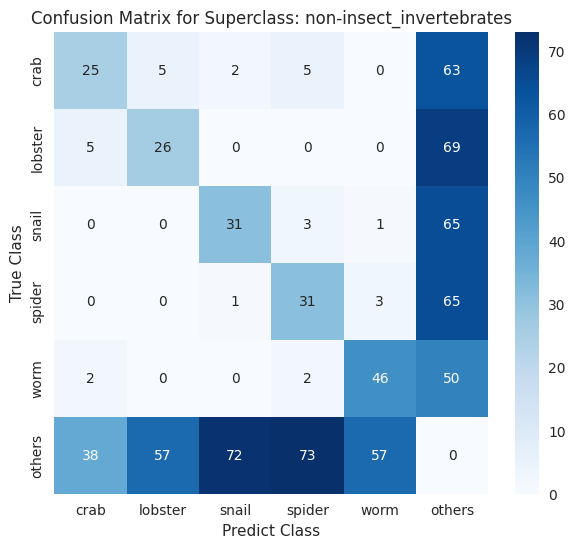

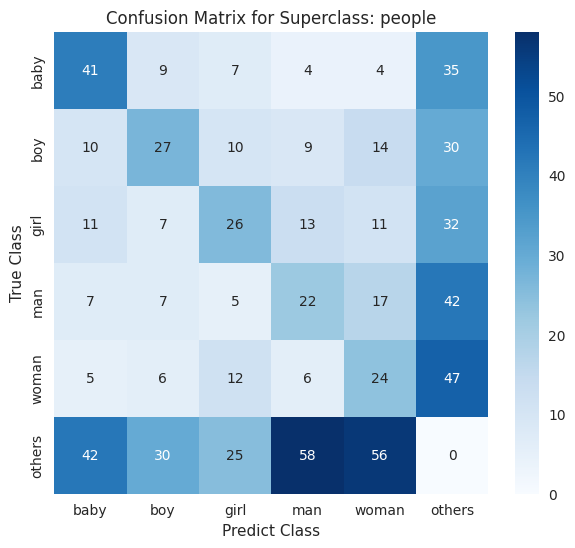

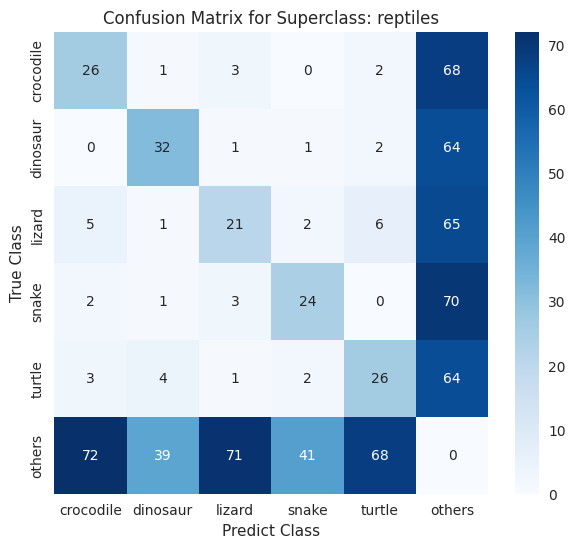

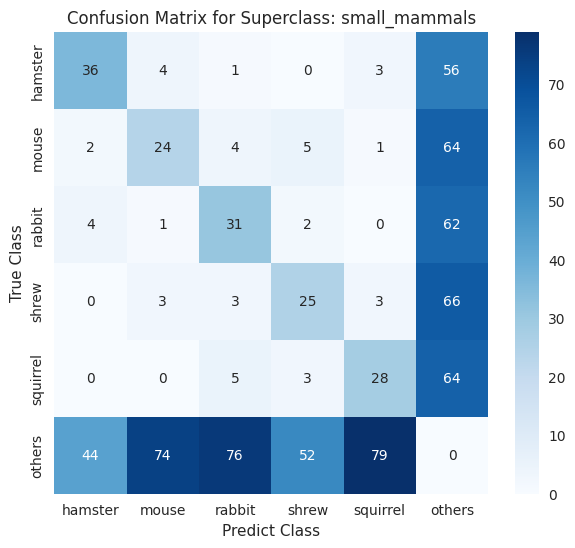

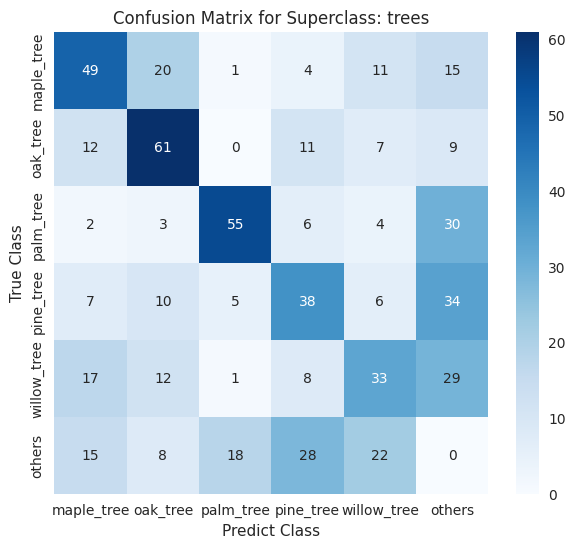

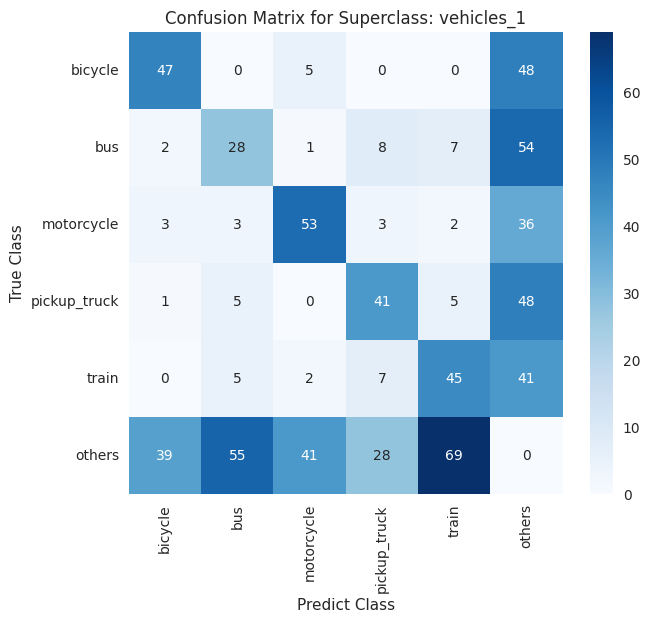

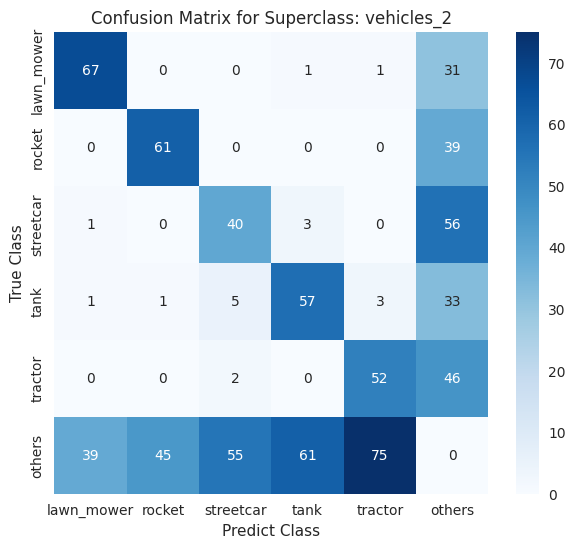

In [16]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [17]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("/kaggle/input/vit_v3/pytorch/default/1/VisionTransformer_CIFAR100_checkpoint.pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"]
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [18]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  16.09 M 
fwd MACs:                                                               8.7254 GMACs
fwd FLOPs:                                                              17.4893 GFLOPS
fwd+bwd MACs:                                                           26.1761 GMACs
fwd+bwd FLOPs:                                                          52.4678 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod